In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

from environment import *
from algorithms.osd1 import OSD1_algorithm
from algorithms.aim import AIM_algorithm
from algorithms.cup import CUP_algorithm
from algorithms.rcosd import RCOSD_algorithm
from algorithms.cosd import COSD_algorithm
from algorithms.constant_quantile import constant_quantile_algorithm
from algorithms.constant import constant_algorithm
from algorithms.past_quantile import past_quantile_algorithm

from tqdm import tqdm

In [2]:
nb_products = 1
rho = np.ones(nb_products)
y_min = 0*np.ones(nb_products)
y_max = 3*np.ones(nb_products)
D = np.sqrt(np.sum((y_max-y_min)*(y_max-y_min)))
gamma_1 = np.min(rho)/D
gamma_2 = 1./D
G = np.sqrt(nb_products)*1.

In [3]:
nb_algs = 4
nb_samples = 10
#horizons = np.power(10.0,np.linspace(np.log10(50),np.log10(10_000),100)).astype(int)
horizons = np.linspace(50,2_000,100).astype(int)
cum_losses = np.zeros((nb_samples, nb_algs+1,len(horizons)))

# Seeding
np.random.seed(1)
seeds = np.random.randint(0,nb_samples,nb_samples)

for seed_id in tqdm(range(nb_samples)) : 

    np.random.seed(seeds[seed_id])
    env = Environment_1(nb_products, horizons[-1])

    algs = [#OGD1_algorithm(nb_products,y_min,y_max,G,gamma_1/20),
        #OGD1_algorithm(nb_products,y_min,y_max,G,gamma_1/5),
        #OSD1_algorithm(nb_products,y_min,y_max,G,gamma_1),
        AIM_algorithm(nb_products,y_min,y_max,G,gamma_1),
        CUP_algorithm(nb_products,y_min,y_max,G,gamma_1), 
        COSD_algorithm(env, nb_products, y_min,y_max,G,gamma_1),
        RCOSD_algorithm(nb_products,y_min,y_max,G,gamma_1)]
        
    for horizon_index in range(len(horizons)) :
        alg_optimal = constant_quantile_algorithm(nb_products,env.demands,horizons[horizon_index],0.5)
        yt, gt, st = np.zeros(nb_products), np.zeros(nb_products), np.zeros(nb_products)
        cum_lt = 0
        
        for t in range(1,horizons[horizon_index]+1) :
            xt = env.get_state(t,yt)
            yt = alg_optimal.next_decision(t,xt,gt,st)
            cum_lt += env.get_loss(t,yt)
            gt = env.get_subgradient(t,yt)
            st = env.get_sales(t,yt)

        cum_losses[seed_id,0,horizon_index] = cum_lt
        assert ((yt>=y_min).all() and (yt<=y_max).all()), "For horizon {} benchmark yt={} is out of bounds.".format(horizons[horizon_index], yt)

    for alg_index in range(0,nb_algs) :
        yt, gt, st = np.zeros(nb_products), np.zeros(nb_products), np.zeros(nb_products)
        cum_lt = 0
        flag_raised = False
        horizon_index = 0

        for t in range(1,horizons[-1]+1) :
            xt = env.get_state(t,yt)
            yt = algs[alg_index].next_decision(t,xt,gt,st)

            if((not flag_raised ) and (yt<xt).any()) :
                print("Undershooting error for alg {} at period {}:".format(alg_index,t))
                print("x_t = {}, y_t = {}".format(xt,yt))
                flag_raised = True
            
            cum_lt += env.get_loss(t,yt)
            if(t in horizons) :
                cum_losses[seed_id,alg_index+1, horizon_index] = cum_lt
                horizon_index += 1
            
            gt = env.get_subgradient(t,yt)
            st = env.get_sales(t,yt)


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


In [4]:
for i in range(nb_algs) :
    print("Alg {} ({}) final regret: {}, final regret std: {}".format(
        i,
        algs[i],
        np.mean((cum_losses[:,i+1,-1]-cum_losses[:,0,-1])),
        np.std(cum_losses[:,i+1,-1]-cum_losses[:,0,-1])
        #np.std(np.sum(losses[:,i+1,:],axis=1)-np.sum(losses[:,0,:],axis=1))
    ))

Alg 0 (AIM gamma=0.3333333333333333) final regret: 25.035718756549567, final regret std: 2.4206686988185817
Alg 1 (CUP gamma=0.3333333333333333) final regret: 42.33262832063065, final regret std: 4.6053192403313465
Alg 2 (COSD gamma=0.3333333333333333) final regret: 25.926513381628318, final regret std: 1.930347297751187
Alg 3 (RCOSD gamma=0.3333333333333333) final regret: 25.327804220407597, final regret std: 2.2648117889801274


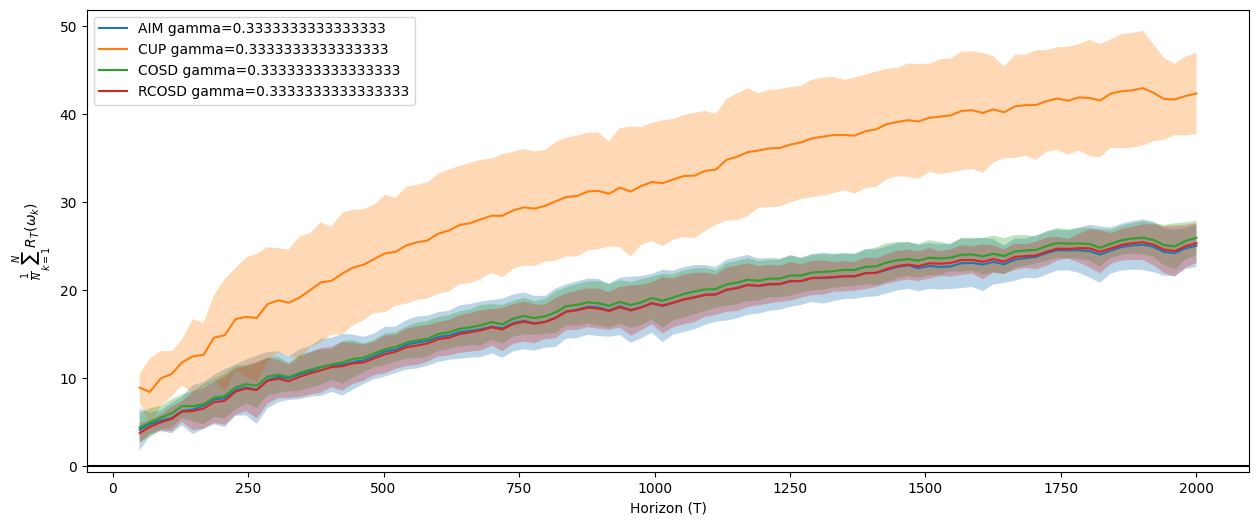

In [5]:
plt.figure(figsize=(15,6))
for i in range(nb_algs) :
    y = np.mean(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0)
    std = np.std(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0)
    plt.plot(horizons, y,label=algs[i])
    plt.fill_between(horizons, y-std,y+std,alpha=0.3)
plt.axhline(0,color="k")
#plt.plot(horizons,np.sqrt(horizons)*D/2*np.sqrt(2/np.pi),"--",color="k",label="theoretical equivalent")
#plt.plot(horizons,np.sqrt(horizons)*D/(4*np.sqrt(2)),"x",color="k",label="theoretical lower bound")
plt.ylabel(r"$\frac{1}{N}\sum_{k=1}^N R_T(\omega_k)$")
plt.xlabel("Horizon (T)")
plt.legend()
plt.show()

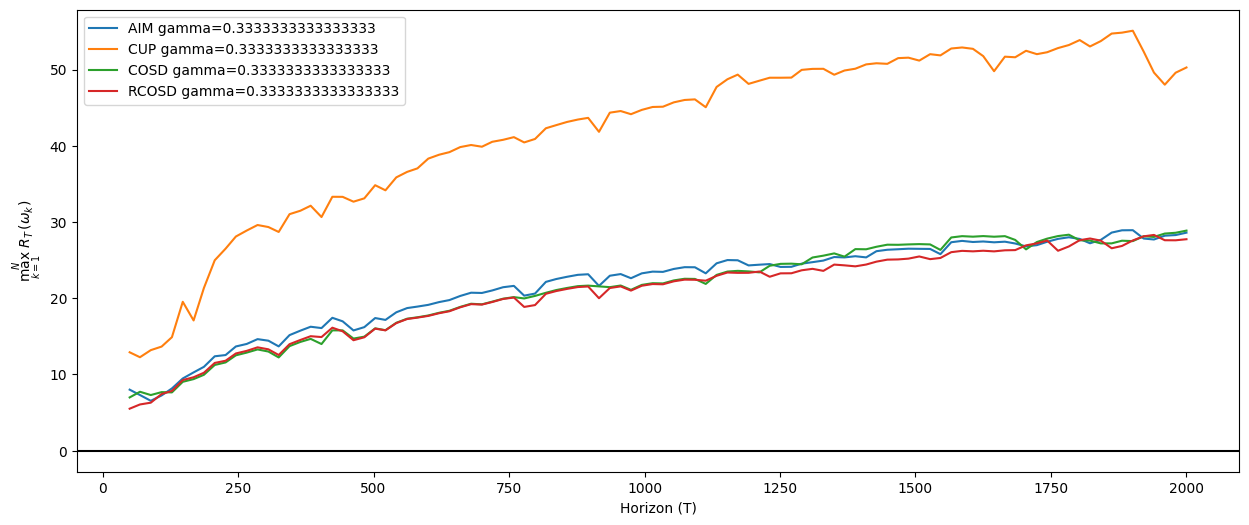

In [7]:
plt.figure(figsize=(15,6))
for i in range(nb_algs) :
    plt.plot(horizons, np.max(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0),label=algs[i])
plt.axhline(0,color="k")
#plt.plot(horizons,(1/(2*gamma_1/20)+gamma_1/20)*D*G*np.sqrt(horizons),"--",color="blue",label="regret upper bound for gamma={}".format(gamma_1/20))
#plt.plot(horizons,(1/(2*gamma_1/5)+gamma_1/5)*D*G*np.sqrt(horizons),"--",color="orange",label="regret upper bound for gamma={}".format(gamma_1/5))
#plt.plot(horizons,(1/(2*gamma_1)+gamma_1)*D*G*np.sqrt(horizons),"--",color="green",label="regret upper bound for gamma={}".format(gamma_1))
plt.ylabel(r"$\max_{k=1}^N \ R_T(\omega_k)$")
plt.xlabel("Horizon (T)")
plt.legend()
plt.show()